In [118]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
import scipy.stats
import csv
import statsmodels.api as sm
import scipy.stats

# Customize default plotting style
%matplotlib inline
import seaborn as sns
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 15

In [2]:
def print_progress_bar(index, total, label):
    """
    prints progress bar for loops.

    :param index : current index of loop
    :param total : total number of indicies to loop over
    :param label : print statement next to progress bar

    """
    n_bar = 20  # Progress bar width
    progress = index / total
    sys.stdout.write('\r')
    sys.stdout.write(f"[{'=' * int(n_bar * progress):{n_bar}s}] {int(100 * progress)}%  {label}")
    sys.stdout.flush()

In [3]:
# Extract data from csv file
year = []
y = []
with open('temp.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter='\t')
    line_count = 0
    for row in csv_reader:
        year = np.append(year, float(row[0][0:4]))
        y = np.append(y, float(row[0][9:15]))


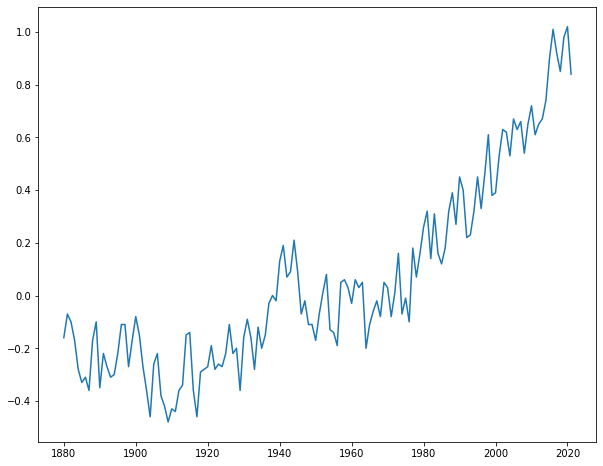

In [4]:
plt.plot(year,y)
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (C)'

In [19]:
# Gaussian noise function wrapper
def noise(size, std):
    return np.random.normal(scale=std, size=size)

# AR(2) model to fit
def y_ar(y, beta, sigma_noise):
    
    Y_p = np.zeros(len(y))
    
    for i in range(len(y)):
        if i == 0 or i == 1:
            Y_p[i] =  y[i]
     
        else:
            Y_p[i] = beta[0]+ beta[1]*y[i-1] + beta[2]*y[i-2] + noise(1, sigma_noise)
            
    return Y_p


In [6]:
#calculate partial-autocorrelations
a = sm.tsa.pacf(y)

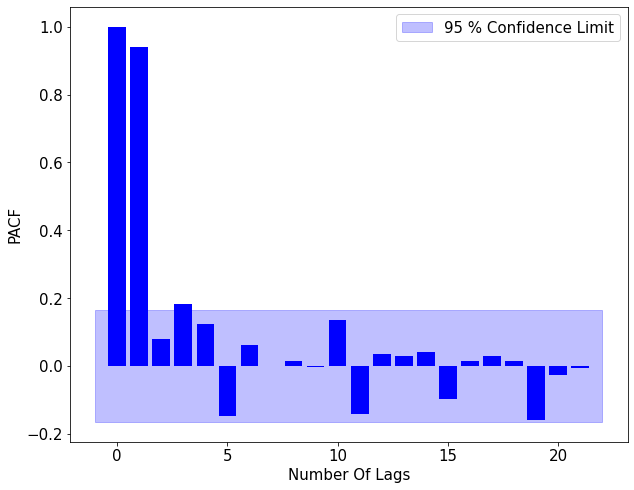

In [132]:
# plot partial-autocorrelations
plt.bar(np.arange(0, 22), a, color='blue')
plt.fill_between(np.arange(-1, 23), -1.96 * (1/len(y))**0.5, 1.96 * (1/len(y))**0.5, alpha =0.25, color = 'blue', label = '95 % Confidence Limit')
plt.ylabel('PACF')
plt.xlabel('Number Of Lags')
plt.legend()
plt.show()

In [8]:
# picked standard devaition for Gaussian Likelihhood (chosen such that the acceptance ratio isn't too large)
sigma_e = 0.1

# counter for calculating the acceptance ratio
count = 0



# prior distributions for beta and noise variance
def prior_probability(beta, noise):
    a = beta[0]     # intercept
    b = beta[1]     # slope
    c = beta[2]
    a_prior = scipy.stats.uniform(-0.5, 2*0.5).pdf(a)
    b_prior = scipy.stats.uniform(-2, 2*2).pdf(b)
    c_prior = scipy.stats.uniform(-2, 2*2).pdf(c)
    noise_prior = scipy.stats.uniform(0.01, 0.1).pdf(noise)
    # log probability transforms multiplication to summation
    return np.log(a_prior) + np.log(b_prior) + np.log(c_prior) + np.log(noise_prior)

# Given beta and noise varinace, the likehood of seeing y
def likelihood_probability(beta, noise):
    y_predict = y_ar(y, beta, noise)
    single_likelihoods = scipy.stats.norm(y_predict, sigma_e).pdf(y)        # we know sigma_e is 3.0
    return np.sum(np.log(single_likelihoods))

# Posterior from Bayes law. MCMC takes care of normalisation
def posterior_probability(beta, noise):
    return likelihood_probability(beta, noise) + prior_probability(beta, noise)

# proposal function for selcting new parameter values
def proposal_function(beta, noise):
    a = beta[0]
    b = beta[1]
    c = beta[2]
    a_new = a + np.random.uniform(-0.01, 0.01)
    b_new = b + np.random.uniform(-0.1, 0.1)
    c_new = c + np.random.uniform(-0.1, 0.1)
    noise_new = noise + np.random.uniform(-0.001, 0.001)
    beta_new = [a_new, b_new, c_new]
    return beta_new, noise_new


# Matropolis Hastings MCMC algorithm
N = int(1e5)
# run the Monte Carlo
beta_0 = [0.1, 0.1, 0.1] # start value
noise_0 = 0.1

results = np.zeros([N,4])            # record the results
results[0,0] = beta_0[0]
results[0, 1] = beta_0[1]
results[0, 2] = beta_0[2]
results[0, 3] = noise_0

for step in range(1, N):               # loop N times
    print_progress_bar(step+1, N, f'{step+1}/{N}')

    beta_old = results[step-1, 0:-1]
    noise_old = results[step-1, -1]
    beta_proposal, noise_proposal = proposal_function(beta_old, noise_old)

    # Use np.exp to restore from log numbers
    prob = np.exp(posterior_probability(beta_proposal, noise_proposal) - posterior_probability(beta_old, noise_old))
    if np.random.uniform(0,1) < prob:
        count += 1
        results[step, 0:-1] = beta_proposal    # jump
        results[step, -1] = noise_proposal
    else:
        results[step, 0:-1] = beta_old         # stay
        results[step, -1] = noise_old

print('', end='\n')

print('acceptance ratio = ', count/N)


[===                 ] 19%  19529/100000

<ipython-input-8-d9c9956a060a>:20: RuntimeWarning: divide by zero encountered in log
  return np.log(a_prior) + np.log(b_prior) + np.log(c_prior) + np.log(noise_prior)


[====================] 100%  100000/100000
0.31574


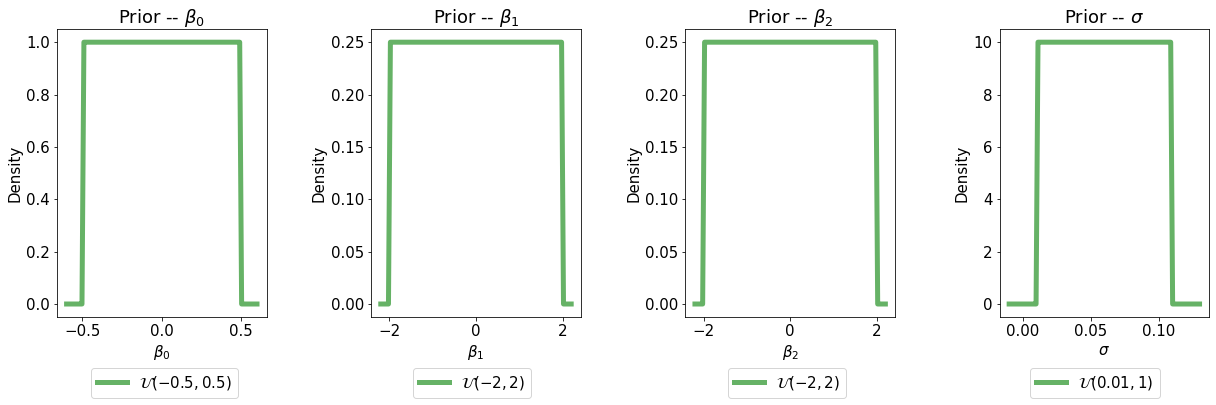

In [110]:
# present the prior results
plt.rcParams["figure.figsize"] = (20,5)

fig = plt.figure()
ax1 = fig.add_subplot(141)
x1 = np.linspace(-0.6,0.6, 100)
ax1.plot(x1, scipy.stats.uniform.pdf(x1,  loc=-0.5, scale=1), 'g-', lw=5, alpha=0.6, label=r'$\mathcal{U}\left(-0.5, 0.5\right)}$')
ax1.set_xlabel(r'$\beta_0$')
ax1.set_ylabel(r'Density')
ax1.title.set_text(r'Prior -- $\beta_0$')
ax1.legend(bbox_to_anchor=(0.9, -0.15))
ax2 = fig.add_subplot(142)
x2 = np.linspace(-2.2,2.2, 100)
ax2.plot(x2, scipy.stats.uniform.pdf(x2,  loc=-2, scale=4), 'g-', lw=5, alpha=0.6, label=r'$\mathcal{U}\left(-2, 2\right)$')
ax2.title.set_text(r'Prior -- $\beta_1$')
ax2.set_xlabel(r'$\beta_1$')
ax2.set_ylabel(r'Density')
ax2.legend(bbox_to_anchor=(0.8, -0.15))
ax3 = fig.add_subplot(143)
x3 = np.linspace(-2.2,2.2, 100)
ax3.plot(x3, scipy.stats.uniform.pdf(x3,  loc=-2, scale=4), 'g-', lw=5, alpha=0.6, label=r'$\mathcal{U}\left(-2, 2\right)$')
ax3.title.set_text(r'Prior -- $\beta_2$')
ax3.set_xlabel(r'$\beta_2$')
ax3.set_ylabel(r'Density')
ax3.legend(bbox_to_anchor=(0.8, -0.15))
ax4 = fig.add_subplot(144)
x4 = np.linspace(-0.01,0.13, 100)
ax4.plot(x4, scipy.stats.uniform.pdf(x4,  loc=0.01, scale=0.1), 'g-', lw=5, alpha=0.6, label=r'$\mathcal{U}\left(0.01, 1\right)$')
ax4.title.set_text(r'Prior -- $\sigma$')
ax4.set_xlabel(r'$\sigma$')
ax4.set_ylabel(r'Density')
ax4.legend(bbox_to_anchor=(0.8, -0.15))


# scale subplots tp look tidy
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.5, 
                    hspace=0.4)

plt.show()

[0.0081888  0.78013426 0.20293984 0.01880279]


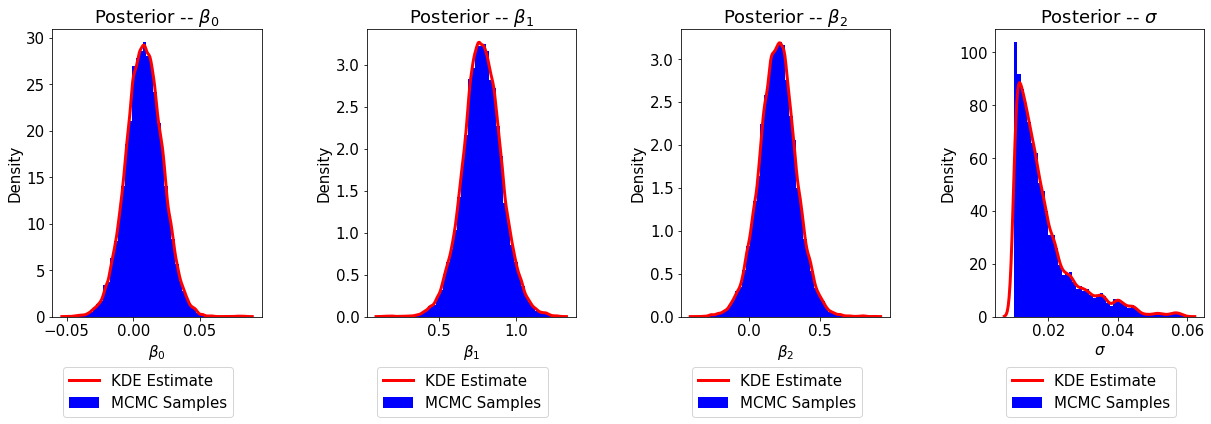

In [91]:
burn_in = 10000
posterior = results[burn_in:, :]
print(posterior.mean(axis=0))        # use average as point estimates

plt.rcParams["figure.figsize"] = (20,5)

# present the posteior results
fig = plt.figure()
ax1 = fig.add_subplot(141)
sns.kdeplot(posterior[:,0], ax = ax1, color = 'red', label = 'KDE Estimate', lw = 3)
ax1.hist(posterior[:,0], bins=50, color='blue', density = True, label = 'MCMC Samples')
ax1.set_xlabel(r'$\beta_0$')
ax1.set_ylabel(r'Density')
ax1.title.set_text(r'Posterior -- $\beta_0$')
ax1.legend(bbox_to_anchor=(0.9, -0.15))
ax2 = fig.add_subplot(142)
sns.kdeplot(posterior[:,1], ax = ax2, color = 'red', label = 'KDE Estimate', lw = 3)
ax2.hist(posterior[:,1], bins=50, color='blue', density = True, label = 'MCMC Samples')
ax2.title.set_text(r'Posterior -- $\beta_1$')
ax2.set_xlabel(r'$\beta_1$')
ax2.set_ylabel(r'Density')
ax2.legend(bbox_to_anchor=(0.9, -0.15))
ax3 = fig.add_subplot(143)
sns.kdeplot(posterior[:,2], ax = ax3, color = 'red', label = 'KDE Estimate', lw = 3)
ax3.hist(posterior[:,2], bins=50, color='blue', density = True, label = 'MCMC Samples')
ax3.title.set_text(r'Posterior -- $\beta_2$')
ax3.set_xlabel(r'$\beta_2$')
ax3.set_ylabel(r'Density')
ax3.legend(bbox_to_anchor=(0.9, -0.15))
ax4 = fig.add_subplot(144)
sns.kdeplot(posterior[:,3], ax = ax4, color = 'red', label = 'KDE Estimate', lw = 3)
ax4.hist(posterior[:,3], bins=50, color='blue', density = True, label = 'MCMC Samples')
ax4.title.set_text(r'Posterior -- $\sigma$')
ax4.set_xlabel(r'$\sigma$')
ax4.set_ylabel(r'Density')
ax4.legend(bbox_to_anchor=(0.9, -0.15))


# scale subplots tp look tidy
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.5, 
                    hspace=0.4)

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.0081888  0.78013426 0.20293984 0.01880279]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


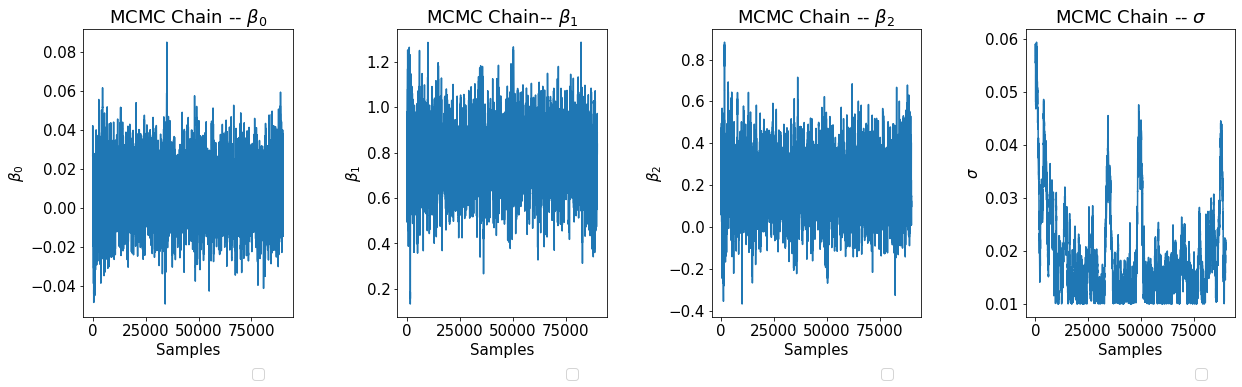

In [158]:
burn_in = 10000
posterior = results[burn_in:, :]
print(posterior.mean(axis=0))        # use average as point estimates

plt.rcParams["figure.figsize"] = (20,5)

# present the posteior results
fig = plt.figure()
ax1 = fig.add_subplot(141)
ax1.plot(posterior[:,0])
ax1.set_ylabel(r'$\beta_0$')
ax1.set_xlabel(r'Samples')
ax1.title.set_text(r'MCMC Chain -- $\beta_0$')
ax1.legend(bbox_to_anchor=(0.9, -0.15))
ax2 = fig.add_subplot(142)
ax2.plot(posterior[:,1])
ax2.title.set_text(r'MCMC Chain-- $\beta_1$')
ax2.set_ylabel(r'$\beta_1$')
ax2.set_xlabel(r'Samples')
ax2.legend(bbox_to_anchor=(0.9, -0.15))
ax3 = fig.add_subplot(143)
ax3.plot(posterior[:,2])
ax3.title.set_text(r'MCMC Chain -- $\beta_2$')
ax3.set_ylabel(r'$\beta_2$')
ax3.set_xlabel(r'Samples')
ax3.legend(bbox_to_anchor=(0.9, -0.15))
ax4 = fig.add_subplot(144)
ax4.plot(posterior[:,3])
ax4.title.set_text(r'MCMC Chain -- $\sigma$')
ax4.set_ylabel(r'$\sigma$')
ax4.set_xlabel(r'Samples')
ax4.legend(bbox_to_anchor=(0.9, -0.15))


# scale subplots tp look tidy
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.5, 
                    hspace=0.4)

plt.show()

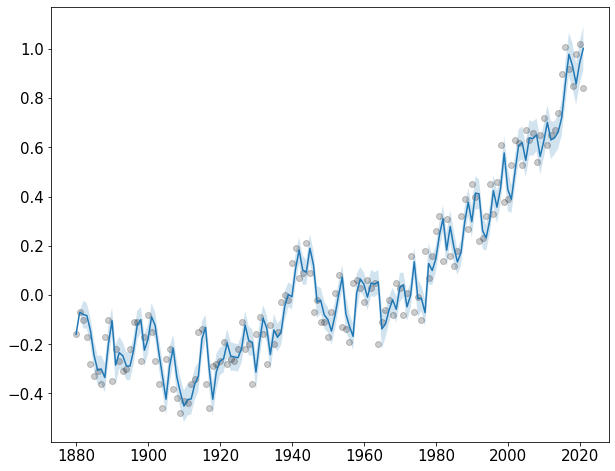

In [139]:
# estimate confidence limits

post = posterior[::, :]


samples = post.shape[0]


y_samples = []

for i in range(samples):
    b = post[i,:]
    y_samples.append(y_ar(y, beta = [b[0], b[1], b[2]], sigma_noise = b[3]))

    
    
y_lower = [np.percentile(np.array(y_samples)[:,i], 2.5) for i in range(len(year))]
y_median = [np.percentile(np.array(y_samples)[:,i], 50) for i in range(len(year))]
y_upper = [np.percentile(np.array(y_samples)[:,i], 97.5) for i in range(len(year))]

plt.plot(year, y_median)
plt.fill_between(year, y_lower, y_upper, alpha = 0.2)
plt.scatter(year, y, c = 'black', alpha = 0.2)


In [140]:
# extrapolate into the future
def future(nyears, y, beta, sigma_noise):
    
    y_future = np.zeros(nyears)
    
    for i in range(nyears):
        
        if i == 0:
            y_future[i] = beta[0]+ beta[1]*y[-1] + beta[2]*y[-2] + noise(1, sigma_noise)
        elif i == 1:
            y_future[i] = beta[0]+ beta[1]*y_future[i-1] + beta[2]*y[-1] + noise(1, sigma_noise)
        else:
            y_future[i] = beta[0]+ beta[1]*y_future[i-1] + beta[2]*y_future[i-2] + noise(1, sigma_noise)
    
    return y_future

In [141]:
# estimate future confidence limits

y_samples_future = []

nyears = 10
year_future = np.arange(year[-1]+1, year[-1]+1+nyears)


for i in range(samples):
    b = post[i,:]
    y_samples_future.append(future(nyears, y, beta = [b[0], b[1], b[2]], sigma_noise = b[3]))
    
y_lower_future = [np.percentile(np.array(y_samples_future)[:,i], 2.5) for i in range(nyears)]
y_median_future = [np.percentile(np.array(y_samples_future)[:,i], 50) for i in range(nyears)]
y_upper_future = [np.percentile(np.array(y_samples_future)[:,i], 97.5) for i in range(nyears)]

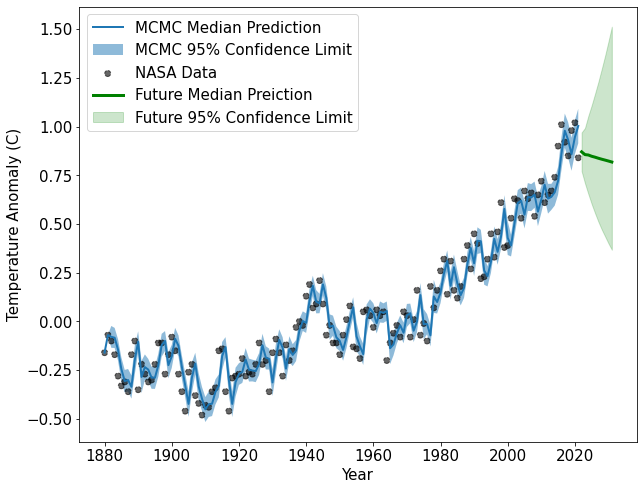

In [148]:
plt.plot(year, y_median, lw = 2, label = 'MCMC Median Prediction')
plt.fill_between(year, y_lower, y_upper, alpha = 0.5, label = 'MCMC 95% Confidence Limit')
plt.scatter(year, y, c = 'black', ls = '--', lw = 1, label = 'NASA Data', alpha = 0.6)
plt.plot(year_future, y_median_future, color='green', lw = 3, label = 'Future Median Preiction')
plt.fill_between(year_future, y_lower_future, y_upper_future, alpha = 0.2, color='green', label = 'Future 95% Confidence Limit')

plt.legend()

plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (C)')

plt.show()